In [13]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
device = 1
os.environ["CUDA_VISIBLE_DEVICES"]= str(device)

In [14]:
import pandas as pd

In [15]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed 

set_seed(42)


In [16]:
saved_model_dir = "best_roberta"
model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir)
tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)


In [17]:
df_heldout = pd.read_csv("df_heldout.csv")


In [18]:
df_heldout.shape


(124553, 14)

In [19]:
df_heldout.columns

Index(['text', 'label', 'path', 'chunk_pos', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10'],
      dtype='object')

In [20]:
categories_dict = {cat: [] for cat in df_heldout['cat1'].unique()}


In [21]:
categories_dict


{'news': [],
 'education': [],
 'history': [],
 'sports': [],
 'government': [],
 'comedy': [],
 'politics': [],
 'arts': [],
 'technology': [],
 'business': []}

In [22]:
for ind, row in df_heldout.iterrows():
    text = row['text']
    cat = row['cat1']
    categories_dict[cat].append(text)


In [12]:
preds = []
for cat in categories_dict:
    print("In category", cat)
    txt = categories_dict[cat]
    tokenized_texts = tokenizer(txt, max_length=256, padding="max_length", truncation=True)
    tokenized_texts_dataset = Dataset.from_dict(tokenized_texts)
    trainer = Trainer(model=model)
    predictions = trainer.predict(tokenized_texts_dataset)
    probs = softmax(predictions.predictions, axis=1)[:, 1]
    labels = []

    for prob in probs:
        if prob > 0.70:
            labels.append(1)
        else:
            labels.append(0)

    prev_right = sum(labels)/len(labels)
    print(f"prev for right-wing politics in {cat} is {prev_right}")
    preds.append((cat, prev_right))


In category news


prev for right-wing politics in news is 0.013263690210591704
In category education


prev for right-wing politics in education is 0.0
In category history


prev for right-wing politics in history is 0.014157973174366617
In category sports


prev for right-wing politics in sports is 0.002364066193853428
In category government


prev for right-wing politics in government is 0.01249024199843872
In category comedy


prev for right-wing politics in comedy is 0.029242819843342035
In category politics


prev for right-wing politics in politics is 0.023474178403755867
In category arts


prev for right-wing politics in arts is 0.006493506493506494
In category technology


prev for right-wing politics in technology is 0.0064516129032258064
In category business


prev for right-wing politics in business is 0.0


# If set threshold to 0.6

In [23]:
preds = []
for cat in categories_dict:
    print("In category", cat)
    txt = categories_dict[cat]
    tokenized_texts = tokenizer(txt, max_length=256, padding="max_length", truncation=True)
    tokenized_texts_dataset = Dataset.from_dict(tokenized_texts)
    trainer = Trainer(model=model)
    predictions = trainer.predict(tokenized_texts_dataset)
    probs = softmax(predictions.predictions, axis=1)[:, 1]
    labels = []

    for prob in probs:
        if prob > 0.60:
            labels.append(1)
        else:
            labels.append(0)

    prev_right = sum(labels)/len(labels)
    print(f"prev for right-wing politics in {cat} is {prev_right}")
    preds.append((cat, prev_right))


In category news


/opt/anaconda/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


prev for right-wing politics in news is 0.22546523530801332
In category education


prev for right-wing politics in education is 0.11171450737005431
In category history


prev for right-wing politics in history is 0.14157973174366617
In category sports


prev for right-wing politics in sports is 0.29314420803782504
In category government


prev for right-wing politics in government is 0.22950819672131148
In category comedy


prev for right-wing politics in comedy is 0.5033942558746737
In category politics


prev for right-wing politics in politics is 0.3192488262910798
In category arts


prev for right-wing politics in arts is 0.18019480519480519
In category technology


prev for right-wing politics in technology is 0.09032258064516129
In category business


prev for right-wing politics in business is 0.21621621621621623


<ipython-input-26-c2782bbb91af>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


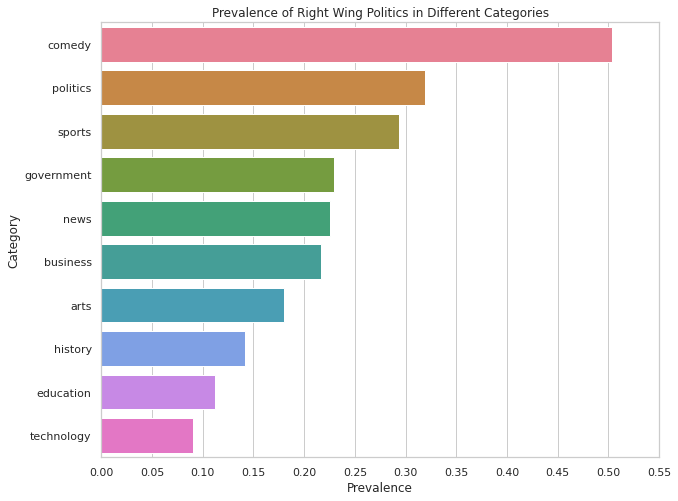

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Category': ["news", "education", "history", "sports", "government"
                , 'comedy', 'politics', 'arts', 'technology', 'business'],
    'Prevalence': [0.22546523530801332, 0.11171450737005431, 0.14157973174366617, 
                   0.29314420803782504,0.22950819672131148, 0.5033942558746737, 
                   0.3192488262910798, 0.18019480519480519, 0.09032258064516129,
                  0.21621621621621623]
}

df = pd.DataFrame(data)

df = df.sort_values(by='Prevalence', ascending=False)

sns.set(style="whitegrid")

colors = sns.color_palette("husl", len(df))

plt.figure(figsize=(10, 8))
bar_plot = sns.barplot(
    x="Prevalence", y="Category", 
    data=df, 
    palette=colors,  
)

bar_plot.set_xlim(0, 0.55)

bar_plot.set_xticks([i/20 for i in range(12)])  # This creates 9 slots (0.00, 0.05, ..., 0.45)

plt.xlabel('Prevalence')
plt.ylabel('Category')
plt.title('Prevalence of Right Wing Politics in Different Categories')

plt.savefig('prevalence_right_wing_in_diff_cat.png')
plt.show()

## If set threshold to 0.65

In [24]:
preds = []
for cat in categories_dict:
    print("In category", cat)
    txt = categories_dict[cat]
    tokenized_texts = tokenizer(txt, max_length=256, padding="max_length", truncation=True)
    tokenized_texts_dataset = Dataset.from_dict(tokenized_texts)
    trainer = Trainer(model=model)
    predictions = trainer.predict(tokenized_texts_dataset)
    probs = softmax(predictions.predictions, axis=1)[:, 1]
    labels = []

    for prob in probs:
        if prob > 0.65:
            labels.append(1)
        else:
            labels.append(0)

    prev_right = sum(labels)/len(labels)
    print(f"prev for right-wing politics in {cat} is {prev_right}")
    preds.append((cat, prev_right))


In category news


prev for right-wing politics in news is 0.061961381313595285
In category education


prev for right-wing politics in education is 0.019394879751745538
In category history


prev for right-wing politics in history is 0.040238450074515646
In category sports


prev for right-wing politics in sports is 0.03309692671394799
In category government


prev for right-wing politics in government is 0.06687483736664064
In category comedy


prev for right-wing politics in comedy is 0.16605744125326372
In category politics


prev for right-wing politics in politics is 0.0892018779342723
In category arts


prev for right-wing politics in arts is 0.030844155844155844
In category technology


prev for right-wing politics in technology is 0.012903225806451613
In category business


prev for right-wing politics in business is 0.02702702702702703
